### Installing packages

In [94]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install geopandas
!pip install shapely


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached geopandas-0.12.1-py3-none-any.whl (1.1 MB)
  Using cached Fiona-1.8.22.tar.gz (1.4 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      Failed to get options via gdal-config: [Errno 2] No such file or directory: 'gdal-config'
      A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-gene

In [12]:
!pip install pdfminer.six


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### Scraping data from pdfs

In [40]:
import pandas as pd
import re
from pdfminer.high_level import extract_text, LAParams

Cleaning pdf

In [54]:
text = extract_text("oct22.pdf", laparams = LAParams(boxes_flow=None))
print(text)

TOMPKINS COUNTY SHERIFFS
OFFICE
Public Information Log

Domestic

Incident Address:  ENFIELD FALLS RD; T ITHACA

ITHACA NY 14850

Time Reported:  23:32:09

Time Occurred Between:  23:32:09 10/31/22 - 23:34:07 10/31/22

Traffic Offense

Incident Address:  BLOCK TRUMANSBURG RD; T ITHACA

ITHACA NY 14850

Time Reported:  23:19:50

Time Occurred Between:  23:19:50 10/31/22 - 23:19:50 10/31/22

Traffic Offense

Incident Address:  STATE ROUTE 13 & WILLOW AVE; C ITHACA

ITHACA NY 14850

Time Reported:  23:09:41

Time Occurred Between:  23:09:41 10/31/22 - 23:09:41 10/31/22

Traffic Stop

Alarm Police

Incident Address:  PLEASANT VALLEY RD; T GROTON
GROTON NY 13073

Time Reported:  23:04:56

Time Occurred Between:  23:04:56 10/31/22 - 23:06:10 10/31/22

Alarm activation

Traffic Offense

Incident Address:  STATE ROUTE 13 N & N TRIPHAMMER RD; V LANSING

ITHACA NY 14850

Time Reported:  22:55:28

Time Occurred Between:  22:55:28 10/31/22 - 22:55:28 10/31/22

11/01/22

Public Information Log

Tr

In [55]:
ts = text.split('\n')
ts = [i for i in ts if i != '']

f = open('clean.txt', 'w')
for i in ts:
    # remove hex characters
    line = re.sub(r'[^\x00-\x7f]',r'', i) 

    # heuristical skipping
    if i in ['TOMPKINS COUNTY SHERIFFS','OFFICE', 'Public Information Log', 'Public Information Log']:
        continue
    if i[:4] == 'Page':
        continue
    if i[0].isdigit():
        continue
            
    print(line, file=f)

f.close()

Need to process some things manually after - very first reason doesn't appear for some reason

In [56]:
reasons = []
incident_address = []
time_reported = []
time_occured = []
comments = []

if_last_is_incident = False
if_last_time_occured = True

tot = ""
prev = ""
with open('clean.txt', 'r') as f:
    for ind, line in enumerate(f.readlines()):
        line = line.strip()
        
        first_colon = line.find(':')

        # heuristic adding to 
        if first_colon != -1:
            before = line[:first_colon]
            after = line[first_colon + 1:]
            if before == 'Incident Address':
                
                # append previous comments if not start as well as next reason
                if ind != 1:
                    comments.append(tot)
                reasons.append(prev)
                tot = ""
                prev = ""
                if_last_time_occured = False


                incident_address.append(after)

                if_last_is_incident = True

            elif before == 'Time Reported':
                if_last_is_incident = False
                time_reported.append(after)
            elif before == 'Time Occurred Between':
                time_occured.append(after)
                if_last_time_occured = True
        else:
            if if_last_is_incident:
                # Add to address
                incident_address[-1] += ' ' + line
            elif if_last_time_occured:
                tot += " " + prev
                prev = line
            # if first line
            elif ind == 0:
                prev = line

            else:
                pass
    comments.append(tot)
len(incident_address), len(time_reported), len(time_occured), len(reasons), len(comments)

(1841, 1841, 1841, 1841, 1841)

In [44]:
df = pd.DataFrame.from_dict({
    'reasons' : reasons,
    'time_occured' : time_occured,
    'time_reported' : time_reported,
    'comments' : comments,
    'incident_address' : incident_address
})


In [45]:
df.to_csv('oct22_cleaned.csv')

Cleaning csvs

In [46]:
f = pd.read_csv('oct22accidents.csv')

In [47]:
f.columns = f.iloc[1]

In [48]:
f.dropna(how='all', axis=1, inplace=True)

In [49]:
f.drop([0,1], inplace=True)
f.to_csv('clean.csv')

In [50]:
f.to_csv('accidents_cleaned.csv')

Getting location from csvs

In [66]:
import os
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.
key = os.environ.get("API_KEY")

import requests
from urllib.parse import quote

def loc(street):
    addy = street
    
    addy = quote(addy)
    response = requests.get(f'https://maps.googleapis.com/maps/api/geocode/json?address={addy}&key={key}')
    resp_json_payload = response.json()
    print(resp_json_payload)
    return resp_json_payload['results'][0]['geometry']['location']['lat'], resp_json_payload['results'][0]['geometry']['location']['lng']

loc('MAIN ST & KIRK RD 13062')

{'results': [], 'status': 'ZERO_RESULTS'}


IndexError: list index out of range

In [68]:
lat = []
long = []

for i in incident_address:
    s = i.split(';')
    print(s)
    if len(s) > 1:
        c = s[0] + ' '+ s[-1][-5:]
    else:
        c = s[0] + ' Tompkins County NY'

    print(c)
    try:
        location = loc(c)
        lat.append(location[0])
        long.append(location[1])
    except:
        lat.append("")
        long.append("")

        


['ENFIELD FALLS RD', ' T ITHACA ITHACA NY 14850']
ENFIELD FALLS RD 14850
{'results': [{'address_components': [{'long_name': 'Enfield Falls Road', 'short_name': 'Enfield Falls Rd', 'types': ['route']}, {'long_name': 'Ithaca', 'short_name': 'Ithaca', 'types': ['locality', 'political']}, {'long_name': 'Tompkins County', 'short_name': 'Tompkins County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'New York', 'short_name': 'NY', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '14850', 'short_name': '14850', 'types': ['postal_code']}], 'formatted_address': 'Enfield Falls Rd, Ithaca, NY 14850, USA', 'geometry': {'bounds': {'northeast': {'lat': 42.41492590000003, 'lng': -76.5461474}, 'southwest': {'lat': 42.40030799999997, 'lng': -76.620048}}, 'location': {'lat': 42.4061947, 'lng': -76.5822069}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'l

In [79]:
df = pd.DataFrame.from_dict({
    'reasons' : reasons,
    'time_occured' : time_occured,
    'time_reported' : time_reported,
    'comments' : comments,
    'incident_address' : incident_address,
    'lat' : lat,
    'long' : long
})
df = df[df['reasons'].str.contains('Traffic')]
df = df[df['lat'] != '']

df.to_csv('traffic_only_oct_22.csv')

### Getting coords for Tompkins County

In [10]:
import json

with open('tompkins-county-coords.json', 'r') as f:
    coords = json.load(f)
coords = coords['coordinates'][0]
coords = [(i,j) for i,j in coords]
coords

[(-76.585989, 42.54991),
 (-76.586538, 42.550175),
 (-76.588873, 42.551303),
 (-76.593778, 42.553668),
 (-76.597834, 42.555596),
 (-76.600887, 42.557047),
 (-76.603346, 42.558188),
 (-76.605987, 42.559413),
 (-76.606694, 42.559808),
 (-76.612027, 42.562783),
 (-76.612174, 42.562865),
 (-76.616286, 42.565432),
 (-76.616696, 42.565688),
 (-76.618239, 42.566652),
 (-76.622875, 42.570692),
 (-76.624439, 42.572055),
 (-76.624667, 42.572253),
 (-76.626761, 42.573868),
 (-76.629357, 42.576273),
 (-76.632496, 42.579182),
 (-76.638075, 42.584404),
 (-76.639216, 42.585472),
 (-76.644424, 42.590795),
 (-76.645317, 42.591708),
 (-76.647666, 42.594419),
 (-76.649649, 42.596708),
 (-76.650231, 42.597379),
 (-76.651716, 42.599216),
 (-76.654228, 42.602325),
 (-76.656226, 42.604798),
 (-76.658634, 42.608413),
 (-76.660242, 42.610827),
 (-76.663139, 42.616354),
 (-76.663556, 42.617149),
 (-76.666543, 42.623457),
 (-76.646243, 42.624292),
 (-76.646039, 42.624294),
 (-76.645709, 42.624304),
 (-76.645507,

Plotting coords

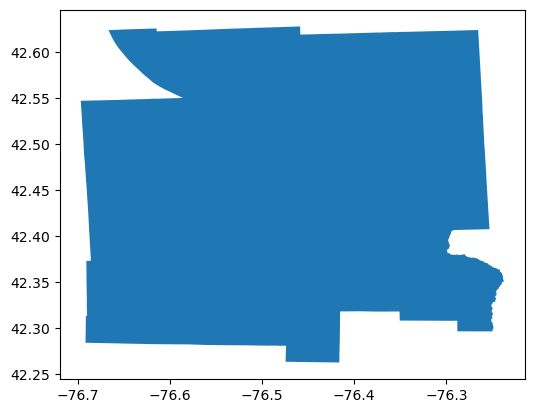

In [25]:

from shapely import geometry
import matplotlib.pyplot as plt
import geopandas as gpd

tompkinscounty = geometry.Polygon(coords)

p = gpd.GeoSeries(tompkinscounty)
p.plot()
plt.show()

In [80]:
x, y  = [i for i, _ in coords], [j for _,j in coords]
up_right_corner = max(x), max(y)
down_left_corner = min(x), min(y)

up_right_corner, down_left_corner

((-76.237695, 42.627419), (-76.696655, 42.262976))

In [31]:
import numpy as np
def gen_random_point_in_polygon(polygon):
    rand_x = np.random.uniform(down_left_corner[0], up_right_corner[0])
    rand_y = np.random.uniform(down_left_corner[1], up_right_corner[1])

    rand_point = geometry.Point(rand_x, rand_y)
    if polygon.contains(rand_point):
        return rand_point
    else:
        return gen_random_point_in_polygon(polygon)

AttributeError: 'DataFrame' object has no attribute 'crs'

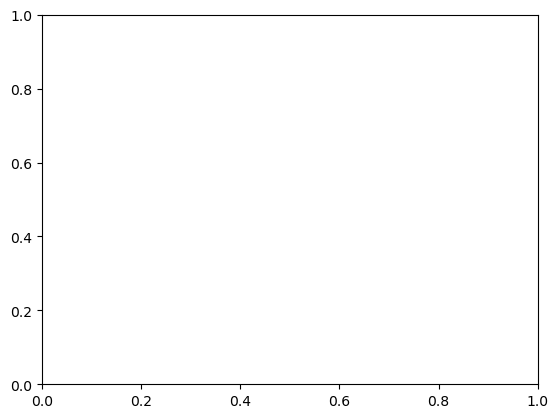

In [34]:
sample_rand_point = gen_random_point_in_polygon(tompkinscounty)

p = gpd.GeoDataFrame([tompkinscounty, sample_rand_point])
p.plot()
plt.show()

### Plotting accidents on Tompkins County Map

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
bbox = (-76.237695, -76.696655, 42.262976, 42.627419)
ruh_m = plt.imread('tompkins_county.png')
df = pd.read_csv('whole_with_time.csv')

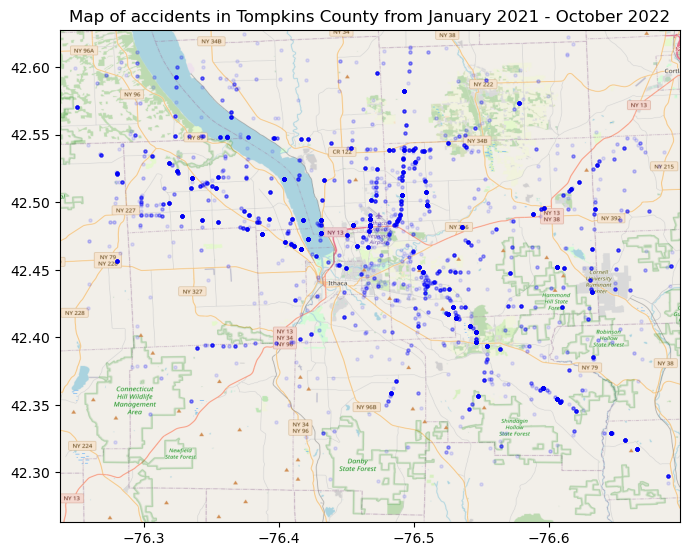

In [108]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.long, df.lat, zorder=1, alpha= 0.1, c='b', s=5)
ax.set_title('Map of accidents in Tompkins County from January 2021 - October 2022')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')

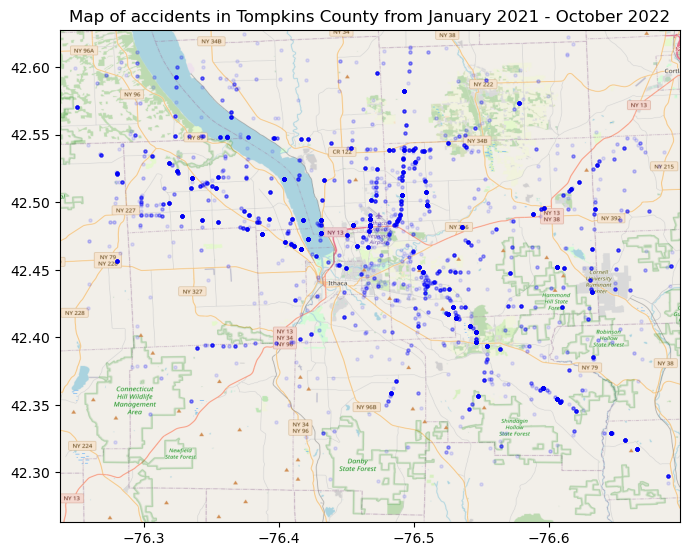

In [109]:
fig, ax = plt.subplots(figsize = (8,7))
tdf = df[df['time_started']]
ax.scatter(df.long, df.lat, zorder=1, alpha= 0.1, c='b', s=5)
ax.set_title('Map of accidents in Tompkins County from January 2021 - October 2022')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')

In [126]:
import datetime

start = datetime.time(23, 0, 0)
end = datetime.time(1, 0, 0)

df['time_started'] = pd.to_datetime(df['time_started'])
tdf = df[(df['time_started'].dt.time <= end) | (df['time_started'].dt.time >= start)]
tdf

Unnamed: 0          reasons                           time_occured  \
5              5  Traffic Offense  00:28:31 07/31/21 - 00:28:31 07/31/21   
6              6  Traffic Offense  00:26:19 07/31/21 - 00:26:19 07/31/21   
7              7  Traffic Offense  00:23:06 07/31/21 - 00:23:06 07/31/21   
23            23  Traffic Offense  00:42:06 07/28/21 - 00:42:06 07/28/21   
70            70  Traffic Offense  00:47:21 07/20/21 - 00:47:21 07/20/21   
...          ...              ...                                    ...   
6695        6695  Traffic Offense  23:45:52 10/08/21 - 23:45:52 10/08/21   
6712        6712  Traffic Offense  00:35:40 10/07/21 - 00:35:40 10/07/21   
6717        6717  Traffic Offense  00:39:09 10/06/21 - 00:39:09 10/06/21   
6733        6733  Traffic Offense  00:51:33 10/04/21 - 00:51:33 10/04/21   
6743        6743  Traffic Offense  00:39:00 10/02/21 - 00:39:00 10/02/21   

     time_reported             comments  \
5         00:28:31        Traffic stop.   
6         00:26:19        Traffic stop.   
7         00:23:06        Traffic stop.   
23        00:42:06    Assist Dryden PD.   
70        00:47:21                        
...            ...                  ...   
6695      23:45:52      Traffic Offense   
6712      00:35:40        Traffic stop.   
6717      00:39:09        Traffic stop.   
6733      00:51:33        Traffic stop.   
6743      00:39:00        Traffic stop.   

                                       incident_address        lat       long  \
5       BLOCK TRUMANSBURG RD; T ULYSSES ITHACA NY 14850  42.491467 -76.588393   
6      RIDGE RD & CONLON RD; T LANSING LANSING NY 14882  42.537994 -76.507725   
7     TRUMANSBURG RD & HAYTS RD; T ITHACA ITHACA NY ...  42.468233 -76.542275   
23      DRYDEN RD & GEORGE RD; T DRYDEN DRYDEN NY 13053  42.489637 -76.328285   
70             SHAFFER RD; T NEWFIELD NEWFIELD NY 14867  42.319418 -76.564601   
...                                                 ...        ...        ...   
6695  WARREN RD; TOMPKINS COUNTY SHERIFF; V LANSING ...  42.487473 -76.467518   
6712  EAST SHORE DR & BLACKCHIN BLVD; V LANSING ITHA...  42.507630 -76.509048   
6717  DRYDEN RD & BAKER HILL RD; T DRYDEN ITHACA NY ...  42.467318 -76.411130   
6733  STATE ROUTE 13; RT 13 RUNWAY; T DRYDEN ITHACA ...  42.711863 -76.032847   
6743  AUBURN RD & WOODSEDGE DR; T LANSING LANSING NY...  42.538195 -76.499422   

            time_started           time_ended  
5    2021-07-31 00:28:31  2021-07-31 00:28:31  
6    2021-07-31 00:26:19  2021-07-31 00:26:19  
7    2021-07-31 00:23:06  2021-07-31 00:23:06  
23   2021-07-28 00:42:06  2021-07-28 00:42:06  
70   2021-07-20 00:47:21  2021-07-20 00:47:21  
...                  ...                  ...  
6695 2021-10-08 23:45:52  2021-10-08 23:45:52  
6712 2021-10-07 00:35:40  2021-10-07 00:35:40  
6717 2021-10-06 00:39:09  2021-10-06 00:39:09  
6733 2021-10-04 00:51:33  2021-10-04 00:51:33  
6743 2021-10-02 00:39:00  2021-10-02 00:39:00  

[490 rows x 10 columns]

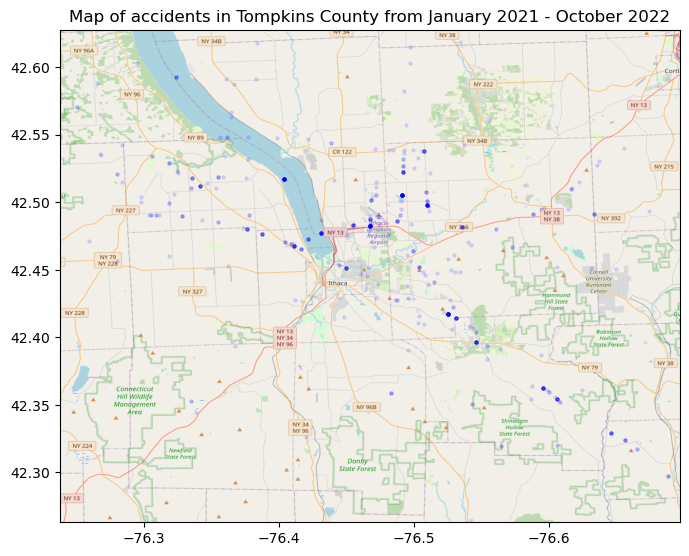

In [127]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(tdf.long, tdf.lat, zorder=1, alpha= 0.1, c='b', s=5)
ax.set_title('Map of accidents in Tompkins County from January 2021 - October 2022')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(ruh_m, zorder=0, extent = bbox, aspect= 'equal')

### Getting train, test, split

In [134]:
import datetime

df = pd.read_csv('whole_with_time.csv', index_col=0)
df['time_started'] = pd.to_datetime(df['time_started'])

first_nov = datetime.date(2022, 11, 1)
first_oct = datetime.date(2022, 10, 1)

tdf = df[(df['time_started'].dt.date < first_nov) | (df['time_started'].dt.date >= first_oct)]
tdf

reasons                           time_occured time_reported  \
0      Traffic Cmplnt  21:44:56 07/31/21 - 21:47:55 07/31/21      21:44:56   
1     Traffic Offense  18:07:24 07/31/21 - 18:07:24 07/31/21      18:07:24   
2     Traffic Offense  17:30:55 07/31/21 - 17:30:55 07/31/21      17:30:55   
3     Traffic Offense  17:16:25 07/31/21 - 17:16:25 07/31/21      17:16:25   
4     Traffic Offense  01:40:20 07/31/21 - 01:40:20 07/31/21      01:40:20   
...               ...                                    ...           ...   
6746  Traffic Offense  02:28:10 10/01/21 - 02:28:10 10/01/21      02:28:10   
6747  Traffic Offense  02:28:10 10/01/21 - 02:28:10 10/01/21      02:28:10   
6748  Traffic Offense  02:28:10 10/01/21 - 02:28:10 10/01/21      02:28:10   
6749  Traffic Offense  01:33:29 10/01/21 - 01:33:29 10/01/21      01:33:29   
6750  Traffic Offense  01:03:37 10/01/21 - 01:03:37 10/01/21      01:03:37   

                                        comments  \
0       Deputy responded to a traffic complaint.   
1               Deputy conducted a traffic stop.   
2               Deputy conducted a traffic stop.   
3                                                  
4                                  Traffic stop.   
...                                          ...   
6746                               Traffic stop.   
6747                               Traffic stop.   
6748                               Traffic stop.   
6749                               Traffic Stop.   
6750                               Traffic stop.   

                                       incident_address        lat       long  \
0     ELMIRA RD; RODEWAY INN ITHACA; T ITHACA ITHACA...  42.362536 -76.595786   
1                   ELMIRA RD; C ITHACA ITHACA NY 14850  42.362536 -76.595786   
2     FLORAL AVE # 408; CEDAR CREEK APTS; C ITHACA I...  42.430065 -76.524652   
3        BLOCK MECKLENBURG RD; T ITHACA ITHACA NY 14850  42.451756 -76.605790   
4     EAST SHORE DR; ROGUES HARBOR; T LANSING LANSIN...  42.529593 -76.500964   
...                                                 ...        ...        ...   
6746  SLATERVILLE RD & BROOKTONDALE RD; T DRYDEN ITH...  42.402591 -76.423707   
6747  SLATERVILLE RD & BROOKTONDALE RD; T DRYDEN ITH...  42.402591 -76.423707   
6748  SLATERVILLE RD & BROOKTONDALE RD; T DRYDEN ITH...  42.402591 -76.423707   
6749  EAST SHORE DR & CAYUGA HEIGHTS RD; V LANSING I...  42.496877 -76.510085   
6750  STATE ROUTE 13 & HALL RD; T DRYDEN ITHACA NY 1...  42.468724 -76.409197   

            time_started           time_ended  
0    2021-07-31 21:44:56  2021-07-31 21:47:55  
1    2021-07-31 18:07:24  2021-07-31 18:07:24  
2    2021-07-31 17:30:55  2021-07-31 17:30:55  
3    2021-07-31 17:16:25  2021-07-31 17:16:25  
4    2021-07-31 01:40:20  2021-07-31 01:40:20  
...                  ...                  ...  
6746 2021-10-01 02:28:10  2021-10-01 02:28:10  
6747 2021-10-01 02:28:10  2021-10-01 02:28:10  
6748 2021-10-01 02:28:10  2021-10-01 02:28:10  
6749 2021-10-01 01:33:29  2021-10-01 01:33:29  
6750 2021-10-01 01:03:37  2021-10-01 01:03:37  

[6751 rows x 9 columns]